<a href="https://colab.research.google.com/github/Dhafanur25/Artefak_TA/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
# Clone the dataset from github and read the csv
!git clone https://github.com/Dhafanur25/data_stunting_bandaharjo.git

df = pd.read_csv('/content/data_stunting_bandaharjo/bandarharjo.csv')
df.tail()

fatal: destination path 'data_stunting_bandaharjo' already exists and is not an empty directory.


,No Anak,JK,Tgl Lahir,BB Lahir,TB Lahir,Prov,Kab/Kota,Kec,Pukesmas,Desa/Kel,...,ZS TB/U,BB/TB,ZS BB/TB,Naik Berat Badan,KEK,TIDAK KEK,JML,ANEMIA,TIDAK ANEMIA,JML.1
3782,3783,P,2024-02-14,3,50,JAWA TENGAH,SEMARANG,SEMARANG UTARA,BANDARHARJO,BANDARHARJO,...,-0.43,Gizi Baik,-1.74,-,0,0,0,0,0,0
3783,3784,P,2024-02-14,3.4,50,JAWA TENGAH,SEMARANG,SEMARANG UTARA,BANDARHARJO,TANJUNGMAS,...,-0.43,Gizi Baik,-0.32,-,0,0,0,0,0,0
3784,3785,L,2024-02-06,3.5,49,JAWA TENGAH,SEMARANG,SEMARANG UTARA,BANDARHARJO,DADAPSARI,...,-0.65,Gizi Baik,0.76,-,0,0,0,0,0,0
3785,3786,L,2024-02-20,3.5,50,JAWA TENGAH,SEMARANG,SEMARANG UTARA,BANDARHARJO,BANDARHARJO,...,0.06,Gizi Baik,0.56,-,0,0,0,0,0,0
3786,3787,P,2024-02-16,3.1,49,JAWA TENGAH,SEMARANG,SEMARANG UTARA,BANDARHARJO,TANJUNGMAS,...,-1.09,Gizi Baik,-0.67,-,0,0,0,0,0,0


In [ ]:
# Check for missing values in the DF
print(df.isnull().values.any())

False


In [ ]:
# Feature Selection
# Dropped because redundant
df.drop('No Anak', axis=1, inplace=True)
df.drop('Tgl Lahir', axis=1, inplace=True)
df.drop('Tanggal Pengukuran', axis=1, inplace=True)

# Dropped because too much noise
df.drop('TIDAK KEK', axis=1, inplace=True)
df.drop('TIDAK ANEMIA', axis=1, inplace=True)
df.drop('ANEMIA', axis=1, inplace=True)
df.drop('KEK', axis=1, inplace=True)
df.drop('BB Lahir', axis=1, inplace=True)
df.drop('TB Lahir', axis=1, inplace=True)
df.drop('JML', axis=1, inplace=True)
df.drop('JML.1', axis=1, inplace=True)
df.drop('Naik Berat Badan', axis=1, inplace=True)

# Dropped because the feature only has one value
df.drop('Prov', axis=1, inplace=True)
df.drop('Kab/Kota', axis=1, inplace=True)
df.drop('Kec', axis=1, inplace=True)
df.drop('Pukesmas', axis=1, inplace=True)
df.drop('Desa/Kel', axis=1, inplace=True)

# Dropped because it is bottom on feature importance
df.drop('BB/U', axis=1, inplace=True)
df.drop('ZS BB/U', axis=1, inplace=True)

In [ ]:
# Rename All the columns
df.rename(columns={
    'JK': 'Gender',
    'Usia Saat Ukur': 'Measurement_Age',
    'Berat': 'Weight',
    'Tinggi': 'Height',
    'TB/U': 'Height/Age',
    'BB/TB': 'Weight/Height',
    'ZS TB/U': 'ZS_Height/Age',
    'ZS BB/TB': 'ZS_Weight/Height'
}, inplace=True)

# Rename the categorical features
# Encoding 'Gender' feature
df['Gender'] = df['Gender'].str.strip().map({'L': 'M', 'P': 'F'})

# Encoding 'Weight/Height' feature
df['Weight/Height'] = df['Weight/Height'].map({
    'Gizi Buruk': 'Severely Wasted',
    'Gizi Kurang': 'Wasted',
    'Gizi Baik': 'Normal',
    'Risiko Gizi Lebih': 'Risk of Overweight',
    'Gizi Lebih': 'Overweight',
    'Obesitas': 'Obese'
})

# Encoding 'Height/Age' feature
df['Height/Age'] = df['Height/Age'].map({
    'Normal': 'Normal',
    'Pendek': 'Stunted',
    'Sangat Pendek': 'Severely Stunted'
})

# Change the 'Measurement_Age' data
df['Measurement_Age'] = df['Measurement_Age'].str.replace('Tahun', 'Year').str.replace('Bulan', 'Month').str.replace('Hari', 'Day')

In [ ]:
df.head()

,Gender,Measurement_Age,Weight,Height,Height/Age,ZS_Height/Age,Weight/Height,ZS_Weight/Height
0,F,0 Year - 1 Month - 11 Day,3.1,50.1,Stunted,-2.50,Normal,-0.94
1,F,4 Year - 11 Month - 25 Day,17.3,102.9,Normal,-1.35,Normal,0.78
2,M,4 Year - 11 Month - 11 Day,18.9,101.9,Normal,-1.67,Overweight,2.01
3,F,4 Year - 11 Month - 4 Day,14.5,102.0,Normal,-1.47,Normal,-0.97
4,F,4 Year - 10 Month - 29 Day,18.8,100.4,Normal,-1.80,Overweight,2.15


In [ ]:
# Encode the features
# Encoding 'Gender' feature
df['Gender'] = df['Gender'].str.strip().map({'M': 0, 'F': 1})

# Encoding 'Weight/Height' feature
df['Weight/Height'] = df['Weight/Height'].map({
    'Severely Wasted': 0,
    'Wasted': 1,
    'Normal': 2,
    'Risk of Overweight': 3,
    'Overweight': 4,
    'Obese': 5
})

# Encoding 'Height/Age' feature
df['Height/Age'] = df['Height/Age'].map({
    'Normal': 0,
    'Stunted': 1,
    'Severely Stunted': 1
})

# Change the format of the 'Measurement_Age' feature to months
def convert_to_months(age_str):
    pattern = r'(\d+)\s*Year\s*-\s*(\d+)\s*Month\s*-\s*(\d+)\s*Day'
    match = re.match(pattern, age_str)

    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        days = int(match.group(3))

        # Convert the age to total months (ignoring days as they do not contribute to full months)
        total_months = years * 12 + months
        return total_months
    else:
        # Handle cases where the format doesn't match
        return None

# Apply the function to the 'Measurement_Age' column
df['Measurement_Age'] = df['Measurement_Age'].apply(convert_to_months)

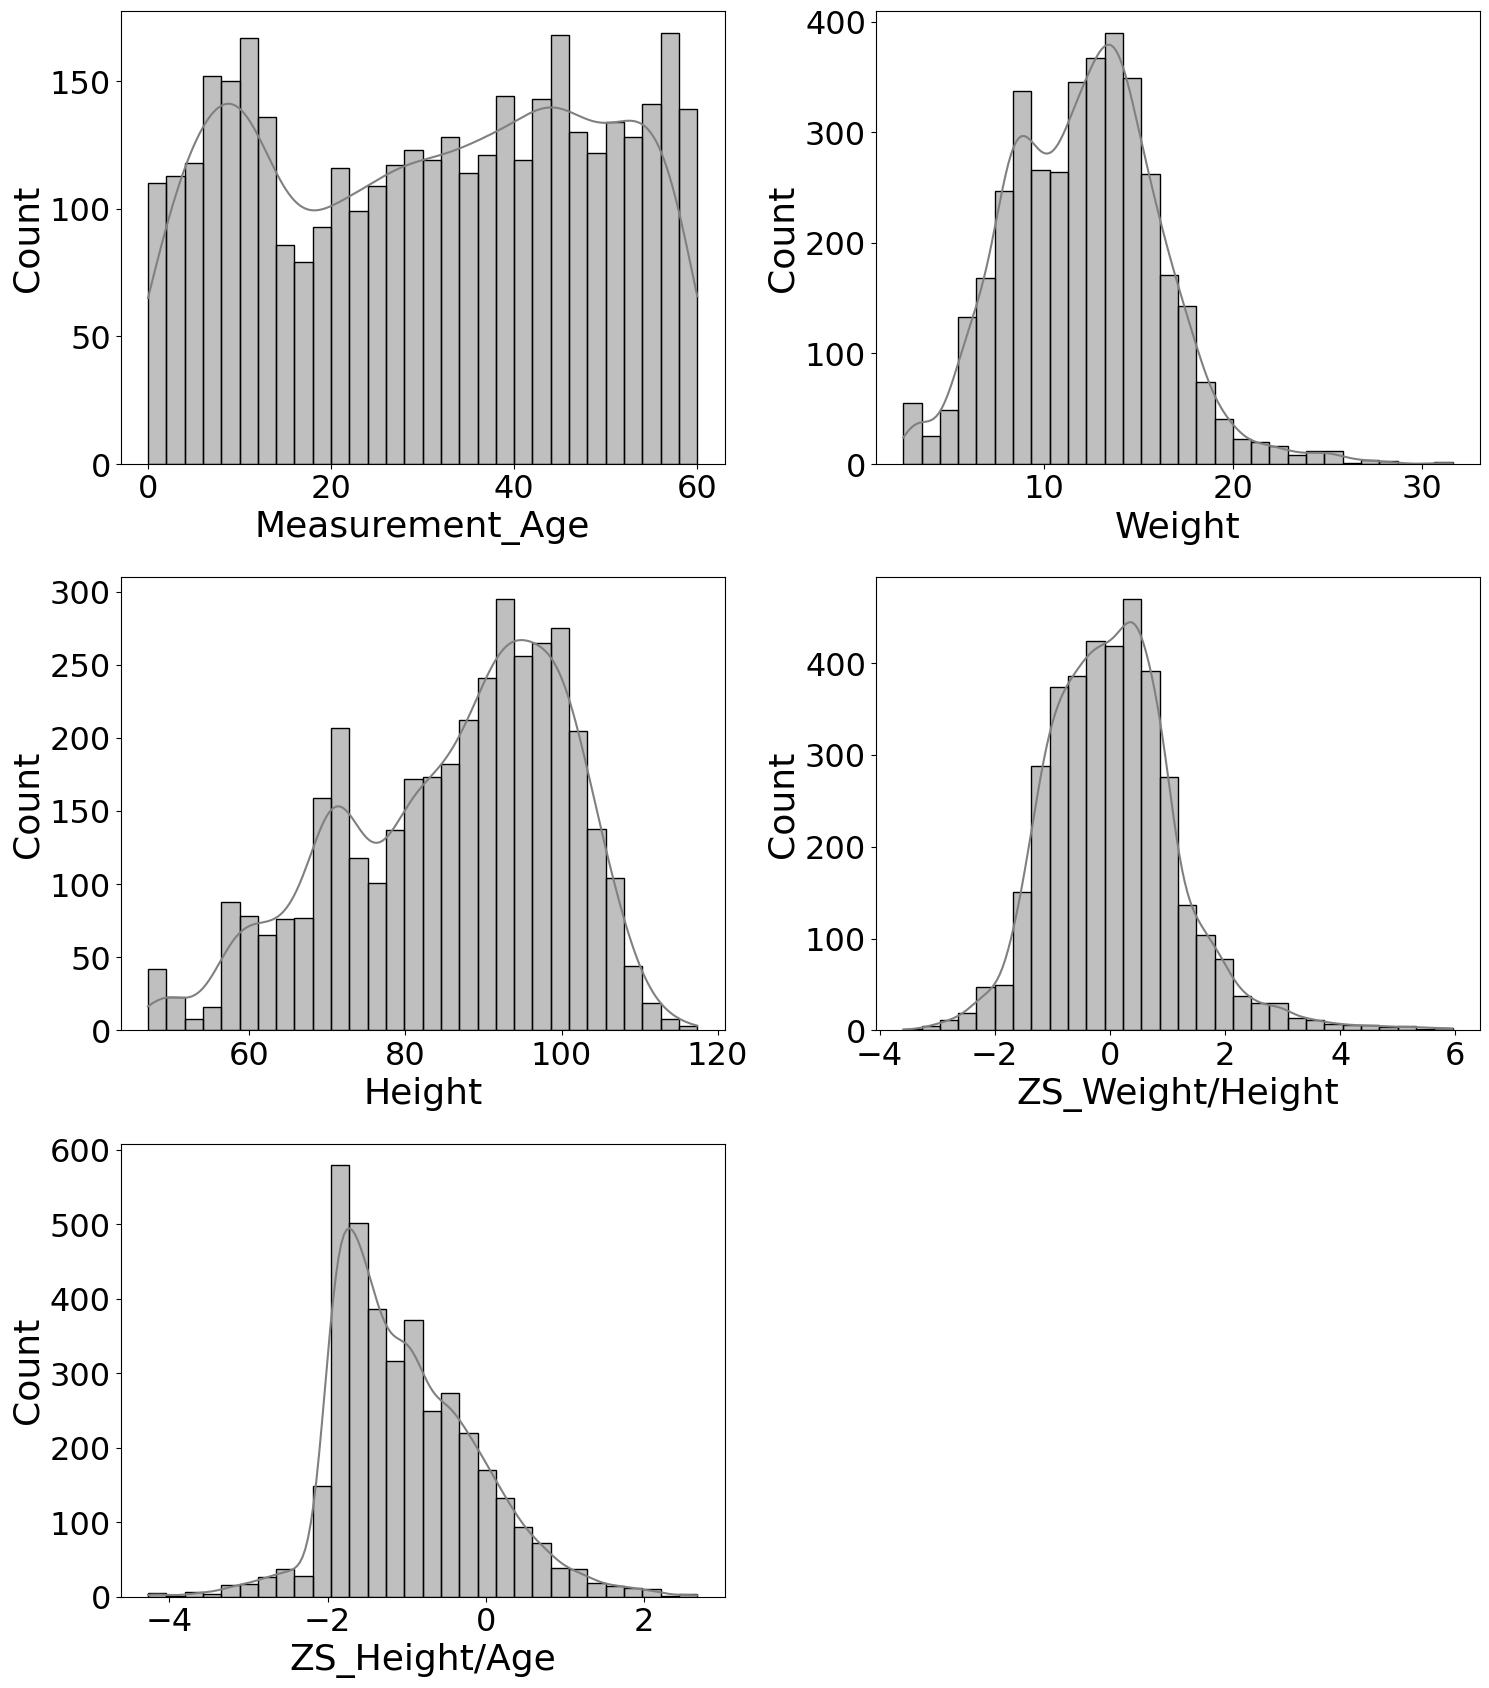

In [ ]:
# Check the spread of data for the numerical features
features = ['Measurement_Age', 'Weight', 'Height', 'ZS_Weight/Height', 'ZS_Height/Age']

plt.figure(figsize=(15, 17))

# Iterate through the features and plot histograms
for i, feature in enumerate(features):
    ax = plt.subplot(3, 2, i + 1)
    sns.histplot(df[feature], kde=True, bins=30, color='grey')
    ax.set_xlabel(feature, fontsize=26)
    ax.set_ylabel('Count', fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=23)

plt.subplot(3, 2, 6).axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

In [ ]:
# Based on the histogram 'Weights', 'ZS_Weight/Height', and 'ZS_Height/Age' features extreme points will be changed to the median
median_berat = df['Weight'].median()
df['Weight'] = df['Weight'].apply(lambda x: median_berat if x > 30 else x)

median_WeightHeight = df['ZS_Weight/Height'].median()
df['ZS_Weight/Height'] = df['ZS_Weight/Height'].apply(lambda x: median_WeightHeight if x > 4 else x)

median_HeightAge = df['ZS_Height/Age'].median()
df['ZS_Height/Age'] = df['ZS_Height/Age'].apply(lambda x: median_HeightAge if x > 3 and x < -4 else x)

# For the remainder of the extreme points will use winsorization to cap their values
df['Weight'] = winsorize(df['Weight'], limits=[0.05, 0.05])
df['ZS_Weight/Height'] = winsorize(df['ZS_Weight/Height'], limits=[0.05, 0.05])
df['ZS_Height/Age'] = winsorize(df['ZS_Height/Age'], limits=[0.05, 0.05])

# Standardize the numerical features with large numbers so they are on the same scale
columns_to_scale = ['Measurement_Age', 'Weight', 'Height', 'ZS_Weight/Height', 'ZS_Height/Age']
df[columns_to_scale] = StandardScaler().fit_transform(df[columns_to_scale])

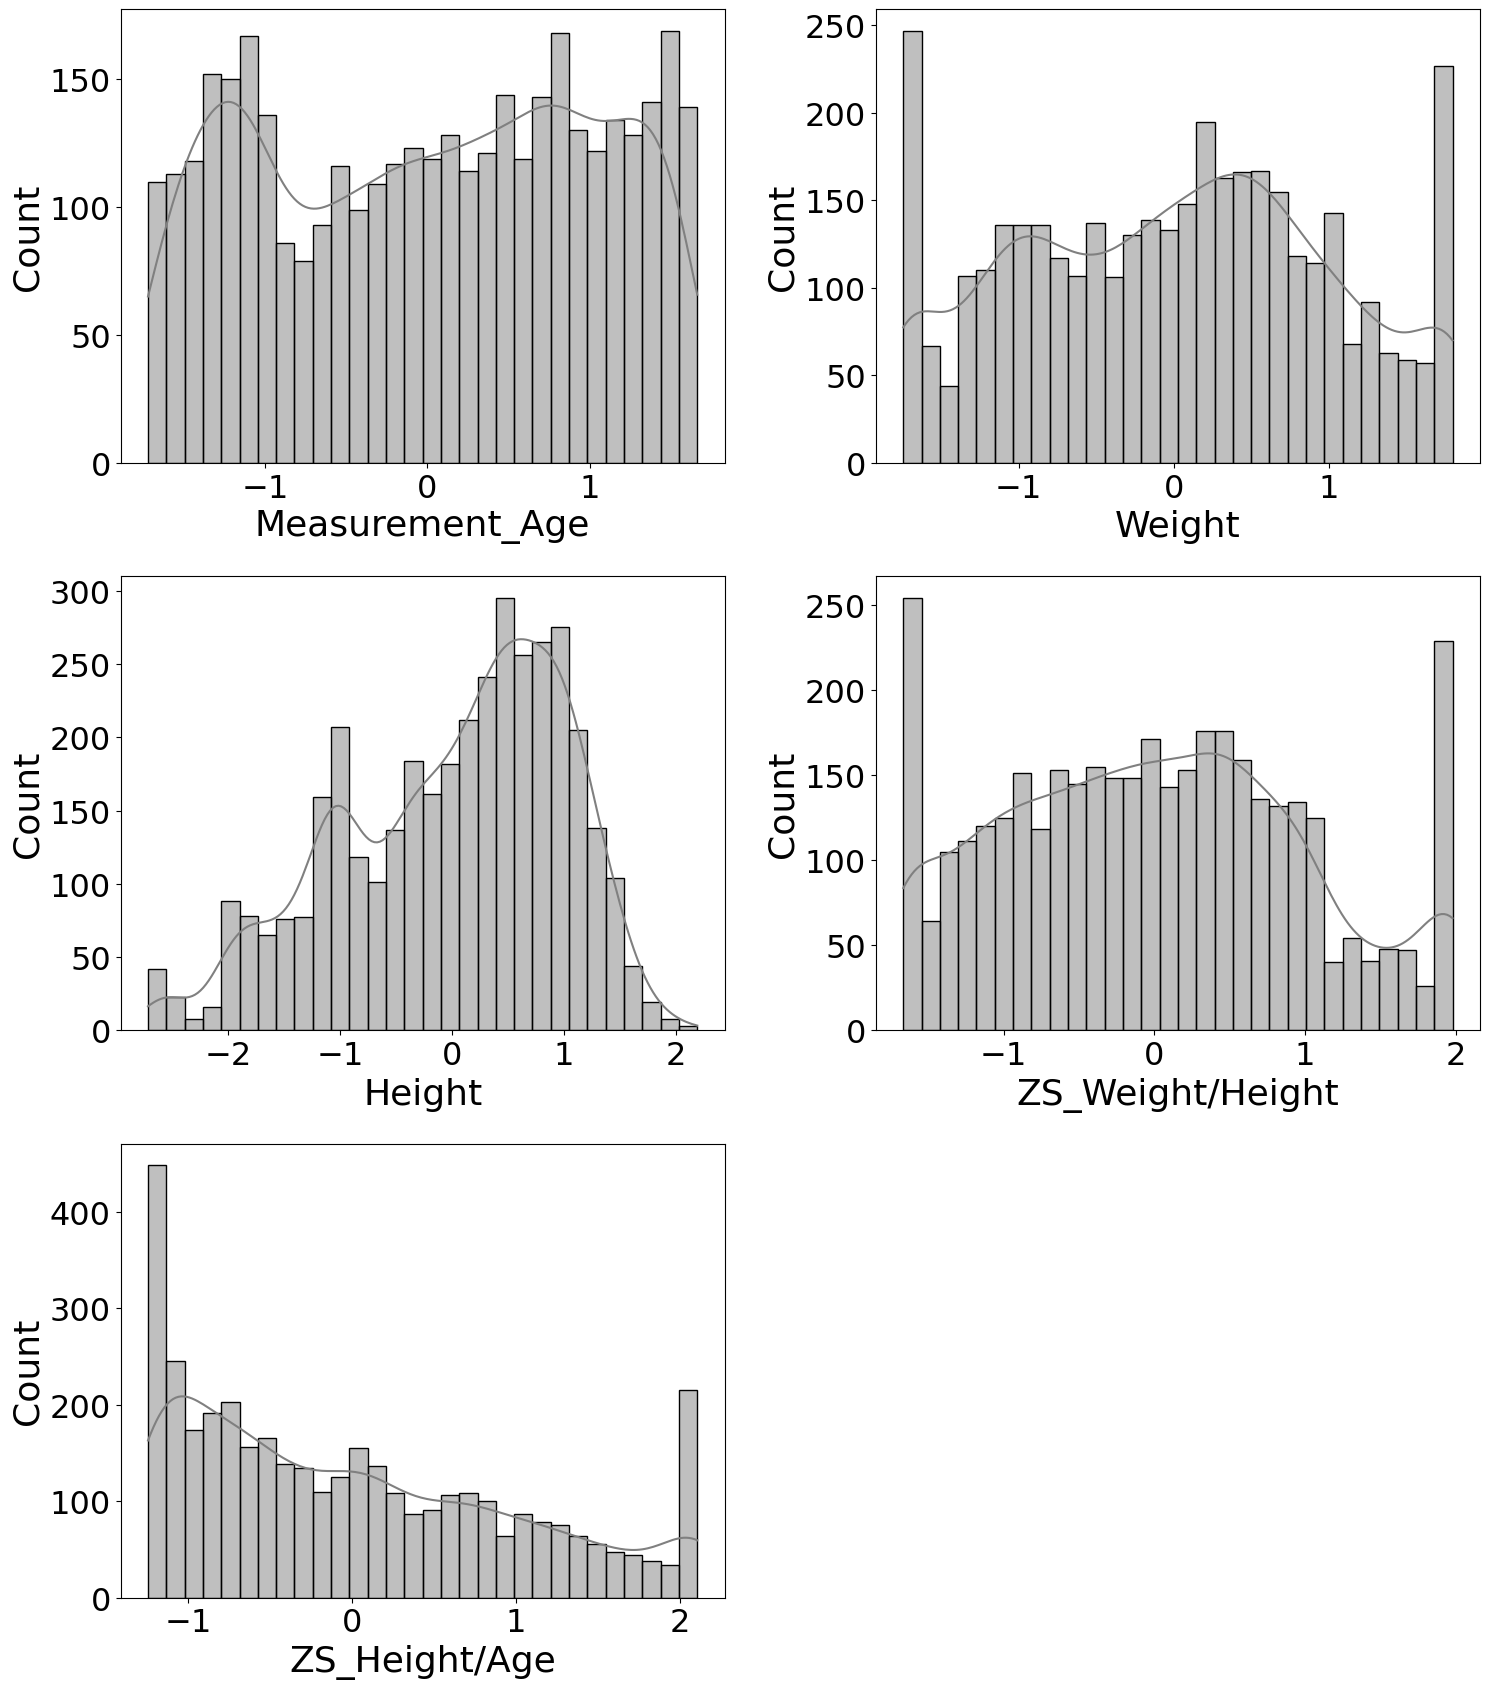

In [ ]:
# Check the spread of data again for the numerical features
features = ['Measurement_Age', 'Weight', 'Height', 'ZS_Weight/Height', 'ZS_Height/Age']

plt.figure(figsize=(15, 17))

# Iterate through the features and plot histograms
for i, feature in enumerate(features):
    ax = plt.subplot(3, 2, i + 1)
    sns.histplot(df[feature], kde=True, bins=30, color='grey')
    ax.set_xlabel(feature, fontsize=26)
    ax.set_ylabel('Count', fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=23)

plt.subplot(3, 2, 6).axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

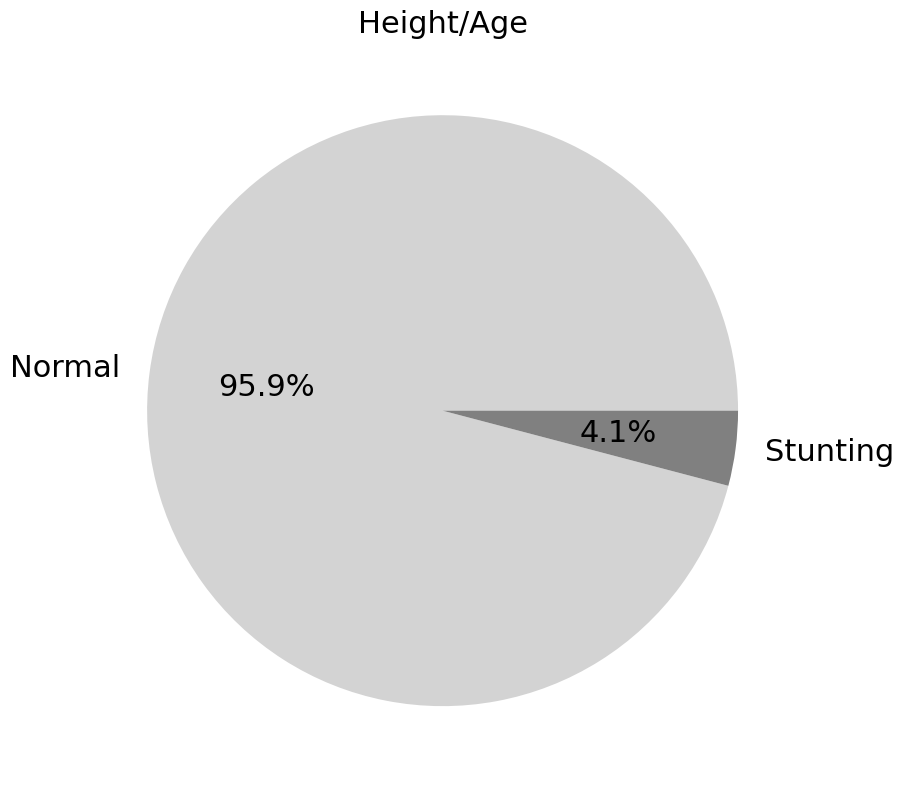

In [ ]:
# Create a copy of the original DataFrame
df_copy = df.copy()

# Map the values of the feature to the labels in the copy
label_mapping = {1: 'Stunting', 0: 'Normal'}
df_copy['Height/Age'] = df_copy['Height/Age'].map(label_mapping)

# Create the figure
plt.figure(figsize=(16, 8))

# Pie chart for 'Height/Age'
feature_counts = df_copy['Height/Age'].value_counts()
plt.pie(
    feature_counts,
    labels=feature_counts.index,
    autopct='%1.1f%%',
    colors=['lightgrey', 'grey'],
    radius=1,
    textprops={'fontsize': 22}
)

plt.title('Height/Age',fontsize=22)
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into features and target
X = df.drop(columns=['Height/Age'])
y = df['Height/Age']

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the training dataset
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# The data after Data preprocessing
df.head()

,Gender,Measurement_Age,Weight,Height,Height/Age,ZS_Height/Age,Weight/Height,ZS_Weight/Height
0,1,-1.665147,-1.745136,-2.496605,1,-1.244199,2,-1.025606
1,1,1.605437,1.486327,1.180654,0,-0.431884,2,0.814099
2,0,1.605437,1.799232,1.111009,0,-0.838041,4,1.979959
3,1,1.605437,0.689839,1.117973,0,-0.584193,2,-1.057694
4,1,1.549048,1.799232,1.006541,0,-1.003043,4,1.979959



Linear SVM:

Linear SVM Accuracy: 98.86%
Linear SVM F1-Score: 94.24%
Linear SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1084
           1       0.80      1.00      0.89        53

    accuracy                           0.99      1137
   macro avg       0.90      0.99      0.94      1137
weighted avg       0.99      0.99      0.99      1137


RBF SVM:

RBF SVM Accuracy: 98.68%
RBF SVM F1-Score: 92.51%
RBF SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1084
           1       0.87      0.85      0.86        53

    accuracy                           0.99      1137
   macro avg       0.93      0.92      0.93      1137
weighted avg       0.99      0.99      0.99      1137


Polynomial SVM:

Polynomial SVM Accuracy: 98.59%
Polynomial SVM F1-Score: 92.22%
Polynomial SVM Classification Report:
               precision    

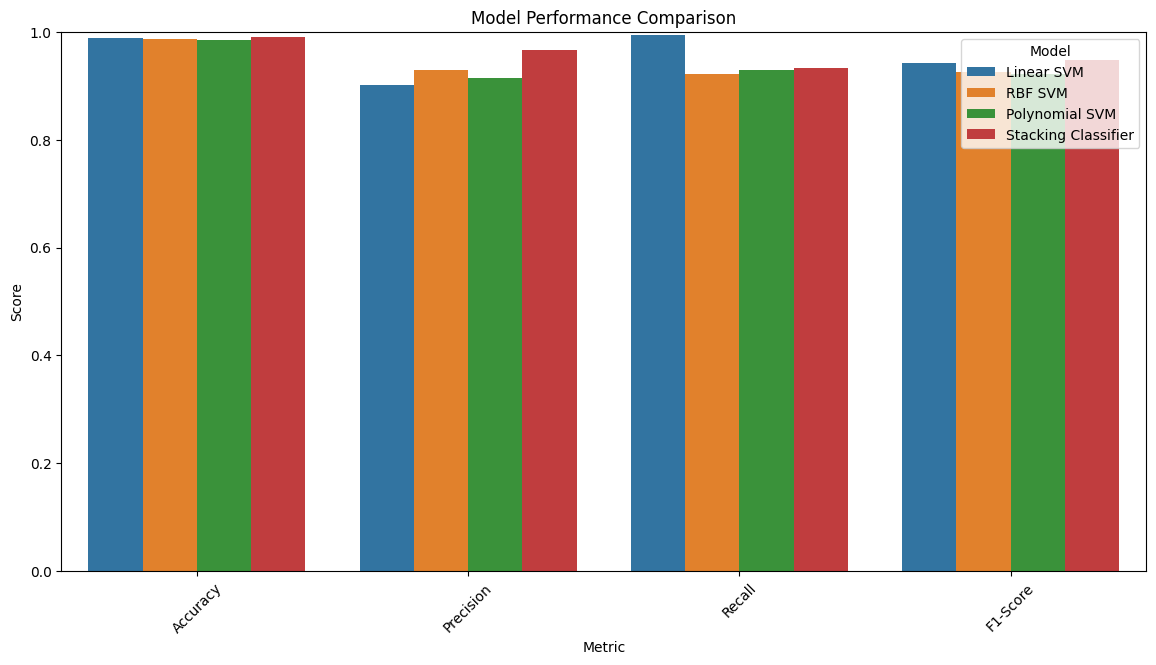

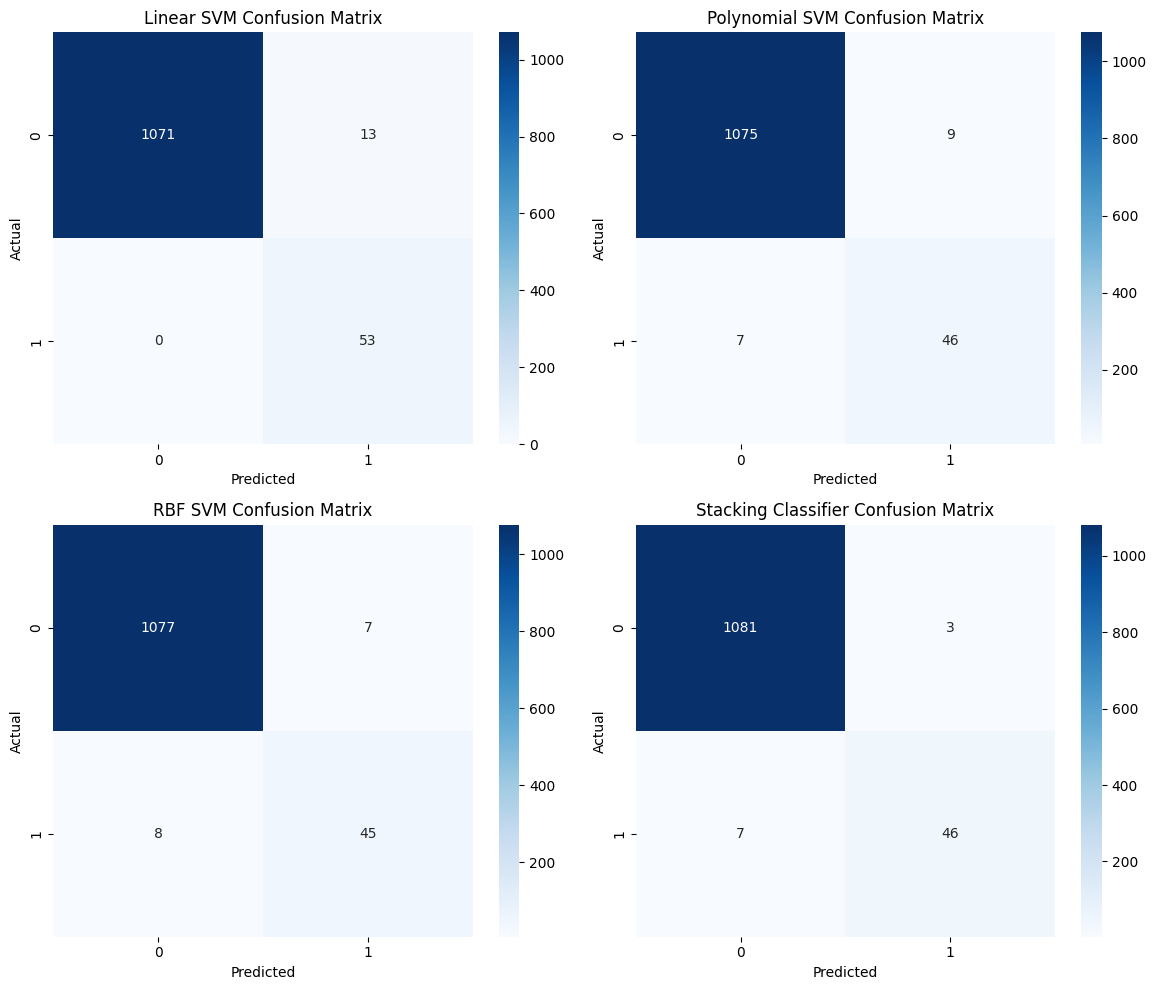

In [ ]:
# Initialize SVM classifiers
svm_linear = SVC(kernel='linear', C=100, probability=True)
svm_rbf = SVC(kernel='rbf', C=100, gamma='scale', probability=True)
svm_poly = SVC(kernel='poly', C=100, degree=3, probability=True)

svm_linear.fit(X_train_smote, y_train_smote)
svm_rbf.fit(X_train_smote, y_train_smote)
svm_poly.fit(X_train_smote, y_train_smote)

# Define base classifiers for stacking
base_classifiers = [
    ('svm_linear', svm_linear),
    ('svm_rbf', svm_rbf),
    ('svm_poly', svm_poly)
]

# Define meta-classifier
meta_classifier = GradientBoostingClassifier()
meta_classifier.fit(X_train_smote, y_train_smote)

# Initialize and train StackingClassifier
stacking_clf = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier, cv=5)
stacking_clf.fit(X_train_smote, y_train_smote)

# Function to display evaluation metrics
def display_evaluation_metrics(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    print(f"\n{model_name} Accuracy: {accuracy*100:.2f}%")
    print(f"{model_name} F1-Score: {f1*100:.2f}%")
    print(f"{model_name} Classification Report:\n", classification_report(y_true, y_pred))
    return accuracy, precision, recall, f1, confusion_matrix(y_true, y_pred)

# Evaluate Linear SVM
print("\nLinear SVM:")
svm_linear_accuracy_smote, svm_linear_precision_smote, svm_linear_recall_smote, svm_linear_f1_smote, svm_linear_cm_smote = display_evaluation_metrics("Linear SVM", y_test, svm_linear.predict(X_test))

# Evaluate RBF SVM
print("\nRBF SVM:")
svm_rbf_accuracy_smote, svm_rbf_precision_smote, svm_rbf_recall_smote, svm_rbf_f1_smote, svm_rbf_cm_smote = display_evaluation_metrics("RBF SVM", y_test, svm_rbf.predict(X_test))

# Evaluate Polynomial SVM
print("\nPolynomial SVM:")
svm_poly_accuracy_smote, svm_poly_precision_smote, svm_poly_recall_smote, svm_poly_f1_smote, svm_poly_cm_smote = display_evaluation_metrics("Polynomial SVM", y_test, svm_poly.predict(X_test))

# Evaluate Stacking Classifier
print("\nStacking Classifier:")
stacking_accuracy, stacking_precision, stacking_recall, stacking_f1, stacking_cm = display_evaluation_metrics("Stacking Classifier", y_test, stacking_clf.predict(X_test))

# Plotting the metrics
metrics_df = pd.DataFrame({
    'Model': ['Linear SVM', 'RBF SVM', 'Polynomial SVM', 'Stacking Classifier'],
    'Accuracy': [svm_linear_accuracy_smote, svm_rbf_accuracy_smote, svm_poly_accuracy_smote, stacking_accuracy],
    'Precision': [svm_linear_precision_smote, svm_rbf_precision_smote, svm_poly_precision_smote, stacking_precision],
    'Recall': [svm_linear_recall_smote, svm_rbf_recall_smote, svm_poly_recall_smote, stacking_recall],
    'F1-Score': [svm_linear_f1_smote, svm_rbf_f1_smote, svm_poly_f1_smote, stacking_f1]
})

metrics_df = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 7))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_df)
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

# Plotting the confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(11.8, 10))

sns.heatmap(svm_linear_cm_smote, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Linear SVM Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

sns.heatmap(svm_rbf_cm_smote, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title('RBF SVM Confusion Matrix')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

sns.heatmap(svm_poly_cm_smote, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Polynomial SVM Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

sns.heatmap(stacking_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_title('Stacking Classifier Confusion Matrix')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')

plt.tight_layout()
plt.show()